In [1]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-19 17:19:41.781378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 17:19:41.895083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 17:19:41.944273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024

In [52]:
data = Dataset('4h')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Multi-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecas

In [87]:
data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv")

In [88]:
# data = pd.read_csv("/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv")
data.drop(columns=['Unnamed: 0','Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
# print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 6   # Number of 15-min we want to look into the future based on the past (Out).
n_past = 6   # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(X, Y, steps, out):
    Xs, Ys = list(), list()
    for i in range(len(X)):
        end = i + steps
        outi = end + out
        if outi > len(X)-1:
            break
        seqx, seqy = X[i:end], Y[end:outi]
        Xs.append(seqx)
        Ys.append(seqy)
    return np.array(Xs), np.array(Ys)


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
data = pd.concat([data, categorical_data], axis = 1)

X = data.drop(columns='Energy')
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

X_train , Y_train =  split_sequence(X_train, Y_train, n_past, n_future)
X_val , Y_val =  split_sequence(X_val, Y_val, n_past, n_future)
X_test , Y_test =  split_sequence(X_test, Y_test, n_past, n_future)

# del data, categorical_data, numerical_data
# del categorical_data, data

3153.0979862889067
4914.042999997735
140.12849999964237
Train sizes:
(464, 438) (464, 1)
Validation sizes:
(41, 438) (41, 1)
Test sizes:
(42, 438) (42, 1)


In [10]:
data['Energy'].mean(), data['Energy'].median(), data['Energy'].min(), data['Energy'].max()

(3153.0979862889067, 3741.6560000032187, 140.12849999964237, 4914.042999997735)

In [91]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.0001, decay_steps=2500, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Bidirectional(LSTM(256 *2, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1)))
    model.add(Bidirectional(LSTM(256 *4, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1)))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(6)))
    model.add(Flatten())
    model.add(Dense(n_future))
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape'])

    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-1d(4h).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)
model = create_model()
history = model.fit(X_train, Y_train[:, :, 0], validation_data=(X_val, Y_val[:, :, 0]), epochs=80, batch_size=4, callbacks=[checkpoint_callback, LearningRateLogger()], verbose=1, shuffle=False)

Epoch 1/80


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2576 - mae: 0.4221 - mape: 738130.8125
Epoch 1: val_loss improved from inf to 0.08051, saving model to ./models/model-1d(4h).keras

Epoch 1: Learning rate is 9.999999747378752e-05
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - loss: 0.2569 - mae: 0.4215 - mape: 738587.5625 - val_loss: 0.0805 - val_mae: 0.2514 - val_mape: 72.7996
Epoch 2/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1158 - mae: 0.2835 - mape: 1011811.0625
Epoch 2: val_loss improved from 0.08051 to 0.07442, saving model to ./models/model-1d(4h).keras

Epoch 2: Learning rate is 9.999999747378752e-05
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1158 - mae: 0.2834 - mape: 1012413.4375 - val_loss: 0.0744 - val_mae: 0.2411 - val_mape: 71.1445
Epoch 3/80
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1106 - mae: 0.2766 - mape: 1009581.5000
Epoch 3: val_loss improved from 0.07442 to 0.06040, saving model to ./models/model-1d(4h).keras

Epoch 3: Learning rate

KeyboardInterrupt: 

In [92]:
from keras.models import load_model
# load model

model = load_model('./models/model-1d(4h).keras')
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step


In [93]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], 35))
zeros[:, :6] = predictions
predictions = scaler_Y.inverse_transform(zeros)
predictions = predictions[:, :6]


zeros = np.zeros((X_test.shape[0], 35))
zeros[:, :6] = Y_test[:, :, 0]
original = scaler_Y.inverse_transform(zeros)
original = original[:, :6]

# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 1031.119096100381
Mean Squared Error (MSE): 1421435.997526114
Root Mean Squared Error (RMSE): 1192.2399077057075
R² Score: 0.2014773854169473
Adjusted R² Score: -0.00683286186558818
Median Absolute Error: 985.8617737847404
Mean Absolute Percentage Error (MAPE): 73.50669570076526 %


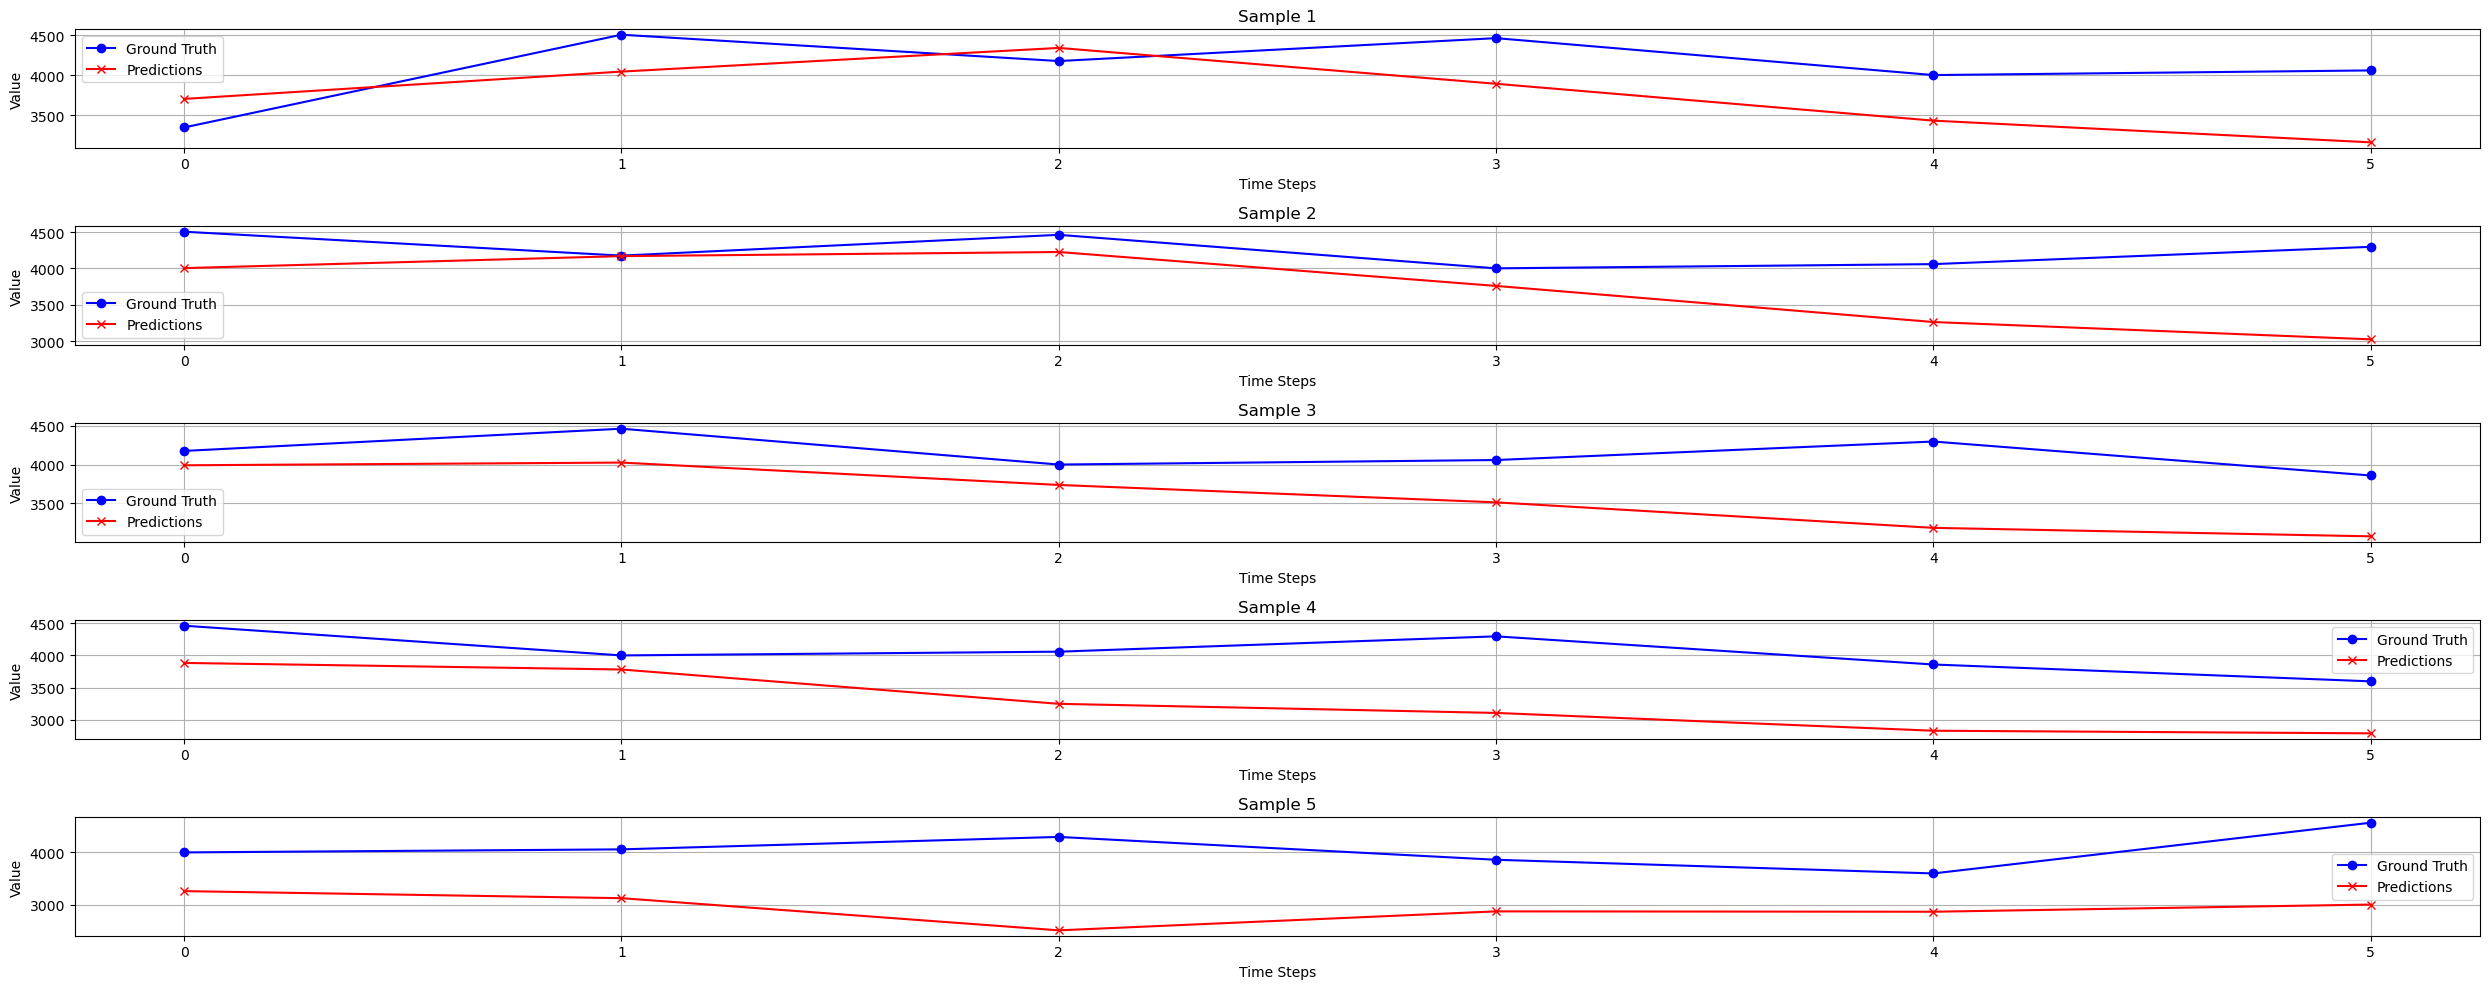

In [94]:
# Number of samples to visualize
n_samples_to_plot = 5  # Number of samples to plot

plt.figure(figsize=(25, 10))

for i in range(n_samples_to_plot):
    plt.subplot(n_samples_to_plot, 1, i + 1)
    plt.plot(range(6), original[i], marker='o', label='Ground Truth', color='blue')
    plt.plot(range(6), predictions[i], marker='x', label='Predictions', color='red')
    plt.title(f'Sample {i + 1}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
